In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scanpy as sc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
adata = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')
adata = adata[(adata.obs['response'] == 'CR') | (adata.obs['response'] == 'NR')]
adata = adata[adata.obs['cell_type'] == 'CD4'].copy()
adata

AnnData object with n_obs × n_vars = 19660 × 6770
    obs: 'channel', 'barcode', 'timepoint', 'timepoint_fine', 'product', 'generic', 'nTisa', 'nAxi', 'CAR', 'n_genes_by_counts', 'total_counts', 'response', 'cdr3_TRA', 'cdr3_TRB', 'batch_id', 'organization', 'n_genes', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'n_counts', 'leiden_0.9', 'cell_type', 'category', 'category_response'
    var: 'feature_types', 'gene_ids-0', 'genome-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'gene_ids-1', 'genome-0-1', 'genome-1-1', 'genome-2-1', 'genome-3-1', 'genome-4-1', 'genome-5-1', 'genome-6-1', 'genome-7-1', 'genome-8-1', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

In [3]:
unique_clusters = adata.obs['leiden_0.9'].unique()
for cluster in unique_clusters:
    adata_cluster = adata[adata.obs['leiden_0.9'] == cluster].copy()
    print(f"{cluster}: {adata_cluster.obs['response'].value_counts()}")

3: response
NR    3956
CR    1996
Name: count, dtype: int64
12: response
NR    988
CR    810
Name: count, dtype: int64
9: response
CR    403
NR    272
Name: count, dtype: int64
8: response
CR    316
NR    216
Name: count, dtype: int64
0: response
CR    254
NR    242
Name: count, dtype: int64
6: response
NR    1753
CR     975
Name: count, dtype: int64
5: response
NR    355
CR    261
Name: count, dtype: int64
11: response
CR    576
NR    376
Name: count, dtype: int64
1: response
CR    1073
NR     393
Name: count, dtype: int64
7: response
CR    272
NR    119
Name: count, dtype: int64
10: response
CR    785
NR    531
Name: count, dtype: int64
2: response
CR    469
NR    197
Name: count, dtype: int64
4: response
CR    389
NR    321
Name: count, dtype: int64
14: response
NR    311
CR     62
Name: count, dtype: int64
13: response
NR    868
CR    119
Name: count, dtype: int64
15: response
NR    2
Name: count, dtype: int64


/tmp/ipykernel_227745/199898528.py:78: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_227745/199898528.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  pr_interp = interp(mean_recall, recall[::-1], precision[::-1])
/tmp/ipykernel_227745/199898528.py:78: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_227745/199898528.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  pr_interp = interp(mean_recall, recall[::-1], precision[::-1])
/tmp/ipykernel_227745/199898528.py:78: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipyk

Skipping cluster 15 due to insufficient samples or classes


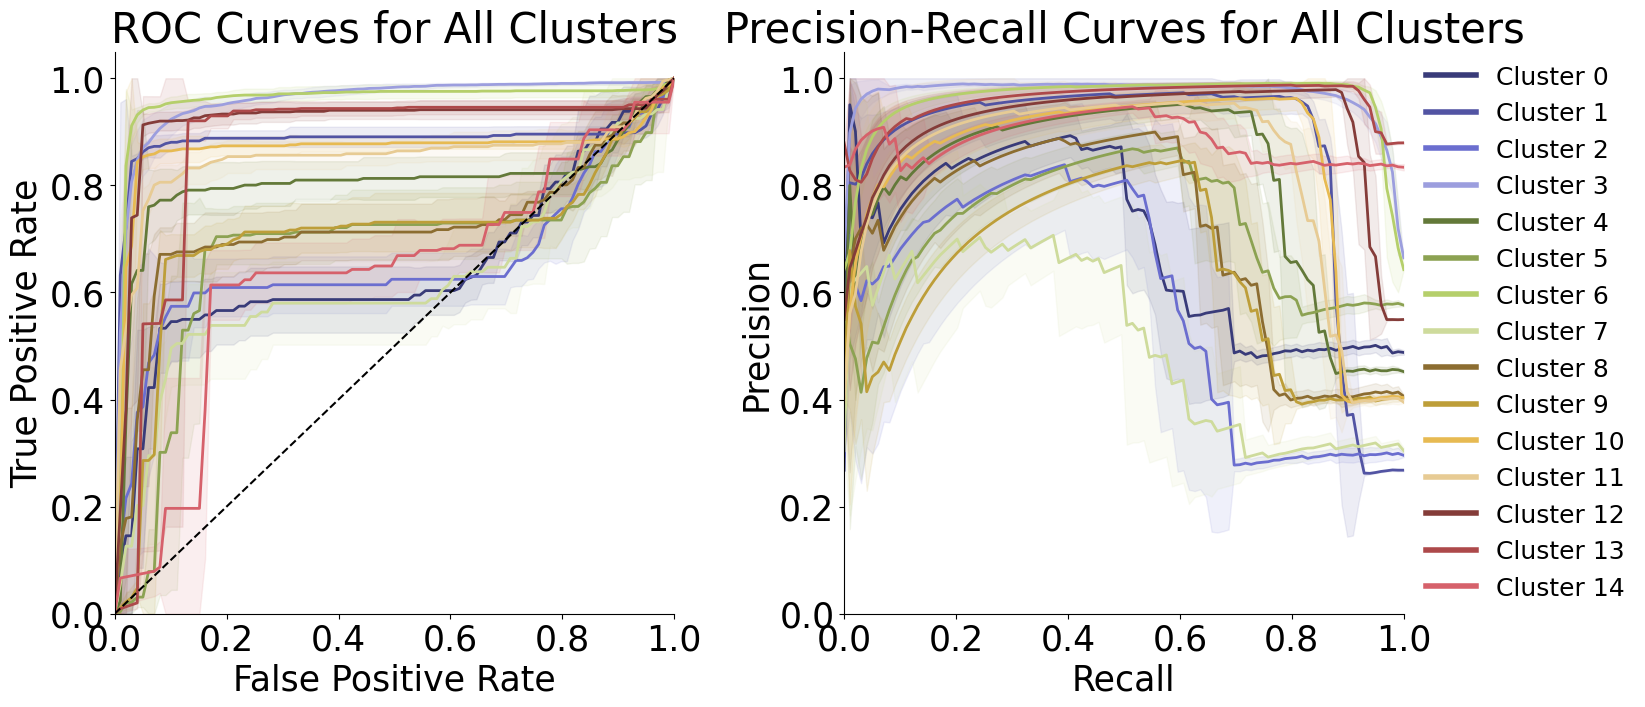


Metrics for all clusters:
    Cluster  n_samples  n_CR  n_NR  Accuracy  Precision  Recall  F1-Score  \
0         0        496   254   242     0.704      0.848   0.484     0.611   
1         1       1466  1073   393     0.945      0.958   0.835     0.891   
2         2        666   469   197     0.815      0.780   0.518     0.622   
3         3       5952  1996  3956     0.918      0.945   0.930     0.938   
4         4        710   389   321     0.866      0.935   0.757     0.836   
5         5        616   261   355     0.755      0.872   0.673     0.759   
6         6       2728   975  1753     0.942      0.973   0.937     0.954   
7         7        391   272   119     0.780      0.722   0.446     0.545   
8         8        532   316   216     0.820      0.899   0.629     0.738   
9         9        675   403   272     0.807      0.836   0.651     0.731   
10       10       1316   785   531     0.919      0.954   0.842     0.894   
11       11        952   576   376     0.880     

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, 
                           precision_recall_curve, auc, roc_curve, precision_score, 
                           recall_score, accuracy_score, f1_score)
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import interp
from cycler import cycler

adata = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')
adata = adata[(adata.obs['response'] == 'CR') | (adata.obs['response'] == 'NR')]
adata = adata[adata.obs['cell_type'] == 'CD4'].copy()

clusters = adata.obs['leiden_0.9'].unique()

roc_curves = []
pr_curves = []
general_metrics = []
confidence_bands = []

n_splits = 5

for cluster in clusters:
    try:
        cluster_adata = adata[adata.obs['leiden_0.9'] == cluster].copy()
        
        # Get data matrix and labels
        data = cluster_adata.X.toarray() if not isinstance(cluster_adata.X, np.ndarray) else cluster_adata.X
        labels = np.where(cluster_adata.obs['response'].values == 'CR', 0, 1)
        
        # Skip if cluster has fewer than 10 samples or only one class
        if len(labels) < 10 or len(np.unique(labels)) < 2:
            print(f"Skipping cluster {cluster} due to insufficient samples or classes")
            continue

        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []
        auc_rocs = []
        auc_prs = []
        
        # For average ROC and PR curves
        tprs = []
        precisions = []
        mean_fpr = np.linspace(0, 1, 100)
        mean_recall = np.linspace(0, 1, 100)
        
        for train_index, test_index in kf.split(data, labels):
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
            
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            model = LogisticRegression(random_state=42, class_weight='balanced')
            model.fit(X_train_scaled, y_train)
            
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            
            accuracy_scores.append(accuracy_score(y_test, y_pred))
            precision_scores.append(precision_score(y_test, y_pred, pos_label=1))
            recall_scores.append(recall_score(y_test, y_pred, pos_label=1))
            f1_scores.append(f1_score(y_test, y_pred, pos_label=1))
            
            # ROC calculations
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            
            # PR calculations
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
            pr_interp = interp(mean_recall, recall[::-1], precision[::-1])
            pr_interp[0] = precision[0]
            precisions.append(pr_interp)
        
        # Calculate average curves and confidence bands
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc_roc = auc(mean_fpr, mean_tpr)
        std_tpr = np.std(tprs, axis=0)
        
        mean_precision = np.mean(precisions, axis=0)
        mean_auc_pr = auc(mean_recall, mean_precision)
        std_precision = np.std(precisions, axis=0)
        
        general_metrics.append({
            'Cluster': int(cluster),
            'n_samples': len(labels),
            'n_CR': sum(labels == 0),
            'n_NR': sum(labels == 1),
            'Accuracy': np.mean(accuracy_scores),
            'Precision': np.mean(precision_scores),
            'Recall': np.mean(recall_scores),
            'F1-Score': np.mean(f1_scores),
            'AUC-ROC': mean_auc_roc,
            'AUC-PR': mean_auc_pr,
            'Std-ROC': np.std(tprs).mean(),
            'Std-PR': np.std(precisions).mean()
        })
        
        roc_curves.append((mean_fpr, mean_tpr, int(cluster), mean_auc_roc))
        pr_curves.append((mean_recall, mean_precision, int(cluster), mean_auc_pr))
        confidence_bands.append({
            'cluster': int(cluster),
            'roc_upper': np.minimum(mean_tpr + std_tpr, 1),
            'roc_lower': np.maximum(mean_tpr - std_tpr, 0),
            'pr_upper': np.minimum(mean_precision + std_precision, 1),
            'pr_lower': np.maximum(mean_precision - std_precision, 0)
        })
        
    except ValueError as e:
        print(f"Error for cluster {cluster}: {e}")
        continue

roc_curves = sorted(roc_curves, key=lambda x: x[2])
pr_curves = sorted(pr_curves, key=lambda x: x[2])
confidence_bands = sorted(confidence_bands, key=lambda x: x['cluster'])

plt.figure(figsize=(20, 8))
plt.rcParams['font.size'] = 25
colors = plt.cm.tab20b.colors

# ROC Curve plot
plt.subplot(1, 2, 1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i, ((mean_fpr, mean_tpr, cluster, mean_auc_roc), conf_band) in enumerate(zip(roc_curves, confidence_bands)):
    color = colors[i % len(colors)]
    plt.plot(mean_fpr, mean_tpr, color=color, 
             label=f'Cluster {cluster} (AUC = {mean_auc_roc:.2f})', 
             linewidth=2)
    plt.fill_between(mean_fpr, conf_band['roc_lower'], conf_band['roc_upper'],
                     color=color, alpha=0.1)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Clusters')

# PR Curve plot
plt.subplot(1, 2, 2)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i, ((mean_recall, mean_precision, cluster, mean_auc_pr), conf_band) in enumerate(zip(pr_curves, confidence_bands)):
    color = colors[i % len(colors)]
    plt.plot(mean_recall, mean_precision, color=color,
             label=f'Cluster {cluster} (AUC = {mean_auc_pr:.2f})',
             linewidth=2)
    plt.fill_between(mean_recall, conf_band['pr_lower'], conf_band['pr_upper'],
                     color=color, alpha=0.1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Clusters')

# Create legend
legend_handles = [Line2D([0], [0], color=colors[i % len(colors)], linewidth=4, label=f'Cluster {cluster}')
                 for i, (_, _, cluster, _) in enumerate(roc_curves)]

plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), 
          fontsize=18, frameon=False)

plt.suptitle('')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

metrics_df = pd.DataFrame(general_metrics)
metrics_df = metrics_df.sort_values('Cluster')
metrics_df = metrics_df.reset_index(drop=True)
print("\nMetrics for all clusters:")
print(metrics_df.round(3))

print("\nTop performing clusters (sorted by AUC-PR):")
top_clusters = metrics_df.sort_values(['AUC-PR', 'AUC-ROC'], ascending=[False, False])
print(top_clusters[['Cluster', 'n_CR', 'n_NR', 'AUC-PR', 'AUC-ROC', 'F1-Score']].round(3))

In [ ]:
adata_cluster = adata[adata.obs['leiden_0.9'].isin(['1','3', '6', '10', '12', '13'])]
cluster_cells = adata_cluster.shape[0]
cluster_cells = adata_cluster.shape[0]
print(f"Number of cells in top clusters: {cluster_cells}")
print(f"Percentage of cells in top clusters: {cluster_cells / adata.shape[0] * 100:.2f}%")

Number of cells in top clusters: 14247
Percentage of cells in top clusters: 72.47%


In [9]:
adata = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')
adata = adata[(adata.obs['response'] == 'CR') | (adata.obs['response'] == 'NR')]
adata = adata[adata.obs['cell_type'] == 'CD8'].copy()
adata

AnnData object with n_obs × n_vars = 27584 × 6770
    obs: 'channel', 'barcode', 'timepoint', 'timepoint_fine', 'product', 'generic', 'nTisa', 'nAxi', 'CAR', 'n_genes_by_counts', 'total_counts', 'response', 'cdr3_TRA', 'cdr3_TRB', 'batch_id', 'organization', 'n_genes', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'n_counts', 'leiden_0.9', 'cell_type', 'category', 'category_response'
    var: 'feature_types', 'gene_ids-0', 'genome-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'gene_ids-1', 'genome-0-1', 'genome-1-1', 'genome-2-1', 'genome-3-1', 'genome-4-1', 'genome-5-1', 'genome-6-1', 'genome-7-1', 'genome-8-1', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

In [5]:
unique_clusters = adata.obs['leiden_0.9'].unique()
for cluster in unique_clusters:
    adata_cluster = adata[adata.obs['leiden_0.9'] == cluster].copy()
    print(f"{cluster}: {adata_cluster.obs['response'].value_counts()}")

0: response
NR    5519
CR    4949
Name: count, dtype: int64
1: response
CR    976
NR    934
Name: count, dtype: int64
3: response
NR    564
CR    179
Name: count, dtype: int64
9: response
NR    2145
CR     814
Name: count, dtype: int64
4: response
NR    794
CR    430
Name: count, dtype: int64
11: response
NR    900
CR    325
Name: count, dtype: int64
7: response
NR    2127
CR    1093
Name: count, dtype: int64
8: response
NR    356
CR    223
Name: count, dtype: int64
10: response
NR    1102
CR     637
Name: count, dtype: int64
2: response
CR    490
NR    219
Name: count, dtype: int64
6: response
NR    155
CR    138
Name: count, dtype: int64
15: response
NR    19
CR    11
Name: count, dtype: int64
5: response
NR    38
CR    37
Name: count, dtype: int64
12: response
NR    146
CR     34
Name: count, dtype: int64
14: response
NR    832
CR    126
Name: count, dtype: int64
13: response
NR    1120
CR     152
Name: count, dtype: int64


/tmp/ipykernel_227745/4198869962.py:75: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_227745/4198869962.py:80: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  pr_interp = interp(mean_recall, recall[::-1], precision[::-1])
/tmp/ipykernel_227745/4198869962.py:75: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_227745/4198869962.py:80: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  pr_interp = interp(mean_recall, recall[::-1], precision[::-1])
/tmp/ipykernel_227745/4198869962.py:75: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp

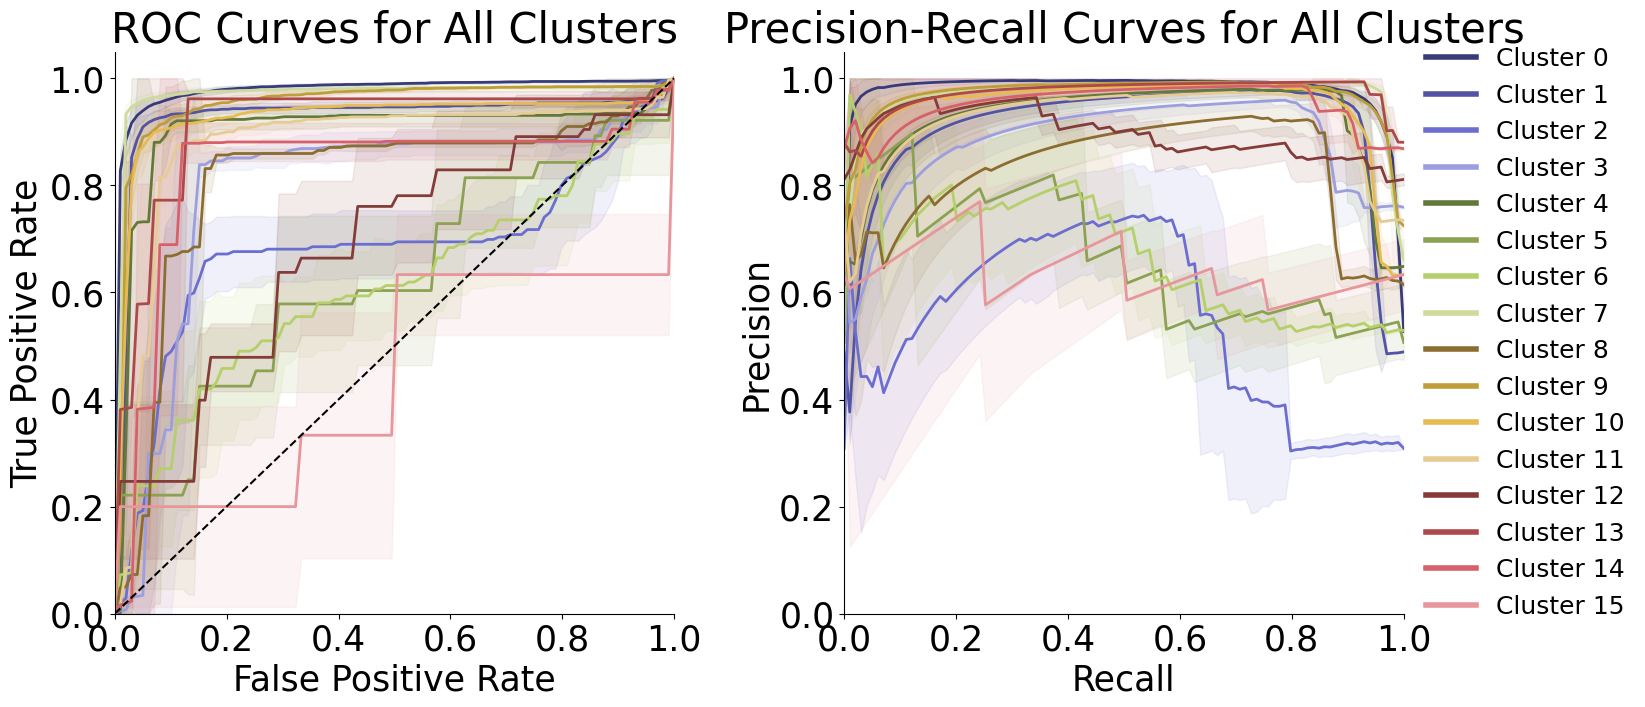


Metrics for all clusters:
    Cluster  n_samples  n_CR  n_NR  Accuracy  Precision  Recall  F1-Score  \
0         0      10468  4949  5519     0.945      0.959   0.935     0.947   
1         1       1910   976   934     0.929      0.960   0.893     0.925   
2         2        709   490   219     0.804      0.727   0.589     0.650   
3         3        743   179   564     0.844      0.937   0.853     0.892   
4         4       1224   430   794     0.918      0.963   0.909     0.935   
5         5         75    37    38     0.547      0.650   0.164     0.244   
6         6        293   138   155     0.624      0.757   0.432     0.548   
7         7       3220  1093  2127     0.956      0.980   0.952     0.966   
8         8        579   223   356     0.846      0.924   0.817     0.867   
9         9       2959   814  2145     0.921      0.948   0.942     0.945   
10       10       1739   637  1102     0.909      0.959   0.894     0.925   
11       11       1225   325   900     0.878     

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve, precision_score, recall_score, accuracy_score, f1_score
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import interp

adata = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')
adata = adata[(adata.obs['response'] == 'CR') | (adata.obs['response'] == 'NR')]
adata = adata[adata.obs['cell_type'] == 'CD8'].copy()

clusters = adata.obs['leiden_0.9'].unique()

roc_curves = []
pr_curves = []
general_metrics = []
confidence_bands = []

n_splits = 5

for cluster in clusters:
    try:
        cluster_adata = adata[adata.obs['leiden_0.9'] == cluster].copy()
        
        # Get data matrix and labels
        data = cluster_adata.X.toarray() if not isinstance(cluster_adata.X, np.ndarray) else cluster_adata.X
        labels = np.where(cluster_adata.obs['response'].values == 'CR', 0, 1)
        
        # Skip if cluster has fewer than 10 samples or only one class
        if len(labels) < 10 or len(np.unique(labels)) < 2:
            print(f"Skipping cluster {cluster} due to insufficient samples or classes")
            continue

        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []
        auc_rocs = []
        auc_prs = []
        
        # For average ROC and PR curves
        tprs = []
        precisions = []
        mean_fpr = np.linspace(0, 1, 100)
        mean_recall = np.linspace(0, 1, 100)
        
        for train_index, test_index in kf.split(data, labels):
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
            
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            model = LogisticRegression(random_state=42, class_weight='balanced')
            model.fit(X_train_scaled, y_train)
            
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            
            accuracy_scores.append(accuracy_score(y_test, y_pred))
            precision_scores.append(precision_score(y_test, y_pred, pos_label=1))
            recall_scores.append(recall_score(y_test, y_pred, pos_label=1))
            f1_scores.append(f1_score(y_test, y_pred, pos_label=1))
            
            # ROC calculations
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            
            # PR calculations
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
            pr_interp = interp(mean_recall, recall[::-1], precision[::-1])
            pr_interp[0] = precision[0]
            precisions.append(pr_interp)
        
        # Calculate average curves and confidence bands
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc_roc = auc(mean_fpr, mean_tpr)
        std_tpr = np.std(tprs, axis=0)
        
        mean_precision = np.mean(precisions, axis=0)
        mean_auc_pr = auc(mean_recall, mean_precision)
        std_precision = np.std(precisions, axis=0)
        
        general_metrics.append({
            'Cluster': int(cluster),
            'n_samples': len(labels),
            'n_CR': sum(labels == 0),
            'n_NR': sum(labels == 1),
            'Accuracy': np.mean(accuracy_scores),
            'Precision': np.mean(precision_scores),
            'Recall': np.mean(recall_scores),
            'F1-Score': np.mean(f1_scores),
            'AUC-ROC': mean_auc_roc,
            'AUC-PR': mean_auc_pr,
            'Std-ROC': np.std(tprs).mean(),
            'Std-PR': np.std(precisions).mean()
        })
        
        roc_curves.append((mean_fpr, mean_tpr, int(cluster), mean_auc_roc))
        pr_curves.append((mean_recall, mean_precision, int(cluster), mean_auc_pr))
        confidence_bands.append({
            'cluster': int(cluster),
            'roc_upper': np.minimum(mean_tpr + std_tpr, 1),
            'roc_lower': np.maximum(mean_tpr - std_tpr, 0),
            'pr_upper': np.minimum(mean_precision + std_precision, 1),
            'pr_lower': np.maximum(mean_precision - std_precision, 0)
        })
        
    except ValueError as e:
        print(f"Error for cluster {cluster}: {e}")
        continue

roc_curves = sorted(roc_curves, key=lambda x: x[2])
pr_curves = sorted(pr_curves, key=lambda x: x[2])
confidence_bands = sorted(confidence_bands, key=lambda x: x['cluster'])

plt.figure(figsize=(20, 8))
plt.rcParams['font.size'] = 25
colors = plt.cm.tab20b.colors

# ROC Curve plot
plt.subplot(1, 2, 1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i, ((mean_fpr, mean_tpr, cluster, mean_auc_roc), conf_band) in enumerate(zip(roc_curves, confidence_bands)):
    color = colors[i % len(colors)]
    plt.plot(mean_fpr, mean_tpr, color=color, 
             label=f'Cluster {cluster} (AUC = {mean_auc_roc:.2f})', 
             linewidth=2)
    plt.fill_between(mean_fpr, conf_band['roc_lower'], conf_band['roc_upper'],
                     color=color, alpha=0.1)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Clusters')

# PR Curve plot
plt.subplot(1, 2, 2)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i, ((mean_recall, mean_precision, cluster, mean_auc_pr), conf_band) in enumerate(zip(pr_curves, confidence_bands)):
    color = colors[i % len(colors)]
    plt.plot(mean_recall, mean_precision, color=color,
             label=f'Cluster {cluster} (AUC = {mean_auc_pr:.2f})',
             linewidth=2)
    plt.fill_between(mean_recall, conf_band['pr_lower'], conf_band['pr_upper'],
                     color=color, alpha=0.1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Clusters')

# Create legend
legend_handles = [Line2D([0], [0], color=colors[i % len(colors)], linewidth=4, label=f'Cluster {cluster}')
                 for i, (_, _, cluster, _) in enumerate(roc_curves)]

plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), 
          fontsize=18, frameon=False)

plt.suptitle('')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

metrics_df = pd.DataFrame(general_metrics)
metrics_df = metrics_df.sort_values('Cluster')
metrics_df = metrics_df.reset_index(drop=True)
print("\nMetrics for all clusters:")
print(metrics_df.round(3))

print("\nTop performing clusters (sorted by AUC-PR):")
top_clusters = metrics_df.sort_values(['AUC-PR', 'AUC-ROC'], ascending=[False, False])
print(top_clusters[['Cluster', 'n_CR', 'n_NR', 'AUC-PR', 'AUC-ROC', 'F1-Score']].round(3))

In [6]:
adata_cluster = adata[adata.obs['leiden_0.9'].isin(['0', '1', '4', '7', '9', '10', '11', '13', '14'])]
cluster_cells = adata_cluster.shape[0]
print(f"Number of cells in top clusters: {cluster_cells}")
print(f"Percentage of cells in top clusters: {cluster_cells / adata.shape[0] * 100:.2f}%")

Number of cells in top clusters: 24975
Percentage of cells in top clusters: 90.54%
